# 于巴西未前往就诊的挂号预约探讨

## Table of Contents
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#question">提出问题</a></li>
<li><a href="#wrangling">数据收集和整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">总结</a></li>
</ul>

<a id='intro'></a>
## 简介

本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，包括 “预约日期 (ScheduledDay)”指患者具体预约就诊的日期；“街区 (Neighborhood) ”指医院所在位置；“福利保障 (Scholarship)”说明病人是否是巴西福利项目 Bolsa Família 的保障人群；请注意最后一列内容的编码：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。

<a id="question"></a>
## 提出问题

数据中除了预约日期、预约的就诊日期、年龄、街区、是否有福利保障外尚有慢性病如高血压、糖尿病、酗酒或行动不便者及简讯通知与否，试着透过这些参数分析与是否前往就诊有无显着关系。

**问题 1**:统计男女预约就诊率比例的差异<br>
**问题 2**:统计福利保障人群是的预约就诊率比例于非福利保障人群的不同<br>
**问题 3**:分析年龄是否是预约就诊率明显变因之一<br>
**问题 4**:慢性病者(高血压、糖尿病)、酗酒、行动不便者或简讯通知的预约就诊率比例<br>

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint as pp
#import os

file_path  =  './KaggleV2-May-2016.csv'
df = pd.read_csv(file_path)
df.head(2)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [2]:
print("是否有缺资料:{}".format(df.isnull().any().any()))

是否有缺资料:False


In [3]:
def draw_plot(top, bottom, title, x_label, legend):
    N = 2
    idx = np.arange(N)
    width = .5
    p1 = plt.bar(idx, top, width)
    p2 = plt.bar(idx, bottom, width, bottom = top)
    plt.title(title)
    plt.xticks(idx, x_label)
    plt.yticks(np.arange(0,1.0,0.2))
    plt.legend((p1[0], p2[0]), legend , loc = 0)
    plt.show()

**问题 1** :统计男女就诊比例的差异

男性出席比例 : 80.03%
女性出席比例 : 79.69%


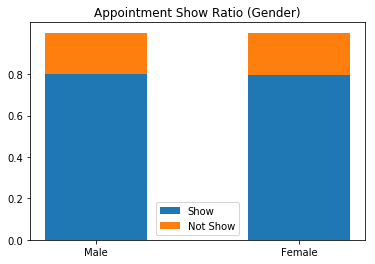

In [4]:
df_gen_m = df[df['Gender'] == 'M']
df_gen_f = df[df['Gender'] == 'F']
show_m = df_gen_m.groupby('No-show')['PatientId'].count()
show_f = df_gen_f.groupby('No-show')['PatientId'].count()
show_sum = [sum(show_m), sum(show_f)] 
show_yes = [show_m['No']/show_sum[0], show_f['No']/show_sum[1]]
show_no = [show_m['Yes']/show_sum[0], show_f['Yes']/show_sum[1]]
print('男性出席比例 : {:.2%}'.format(show_yes[0]))
print('女性出席比例 : {:.2%}'.format(show_yes[1]))
title = 'Appointment Show Ratio (Gender)'
x_label = ['Male', 'Female']
legend = ['Show' ,'Not Show']
draw_plot(show_yes, show_no ,title, x_label,legend )

**答案 1** : 经统计结果观察男性与女性的预约就诊率就诊比例相当接近，皆约80%，无明显统计差异，因此单就性别无法当作预测指标。

**问题 2** :统计福利保障人群是的预约就诊率比例于非福利保障人群的不同

福利保障人群出席比例 : 76.26%
非福利保障人群出席比例 : 80.19%


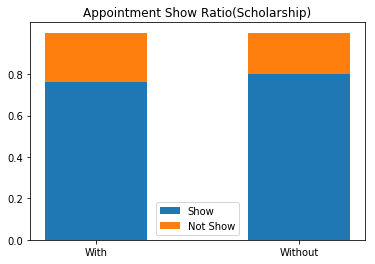

In [5]:
df_with_scholar = df[df['Scholarship'] == 1]
df_without_scholar = df[df['Scholarship'] == 0]
show_with_scholar = df_with_scholar.groupby('No-show')['PatientId'].count()
show_without_scholar = df_without_scholar.groupby('No-show')['PatientId'].count()
show_sum = [sum(show_with_scholar), sum(show_without_scholar)] 

show_yes = [show_with_scholar['No']/show_sum[0], show_without_scholar['No']/show_sum[1]]
show_no = [show_with_scholar['Yes']/show_sum[0], show_without_scholar['Yes']/show_sum[1]]
print('福利保障人群出席比例 : {:.2%}'.format(show_yes[0]))
print('非福利保障人群出席比例 : {:.2%}'.format(show_yes[1]))
title = 'Appointment Show Ratio(Scholarship)'
x_label = ['With', 'Without']
legend = ['Show', 'Not Show']
draw_plot(show_yes,show_no ,title, x_label,legend )

**答案 2** :观察统计结果，福利保障人群预约就诊率的略低于非福利保障人群，其可列为预测参数之一。

**问题 3**:分析年龄是否是预约就诊率明显变因之一

In [6]:
show = []
for row in df['No-show']:
    num = 0;
    if row == 'No' :
        num = 1
    show.append(num)
df['Show'] = show

In [7]:
age_level_list = [ 10, 20, 30, 40, 50, 60, 70 ]
age_level_string = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-']
age_levels = []

for row in df['Age']:
    i = 0    
    while i < len(age_level_list) and row > age_level_list[i]:
        i += 1
    level = age_level_string[i]
    age_levels.append(level)

df['AgeLevel'] = age_levels
#df.loc[:,['Age', 'AgeLevel']].head(5)
#df_age_group = df.groupby(['AgeLevel', 'No-show'])[['PatientId']].count().unstack()
#df_age_group.head(5)

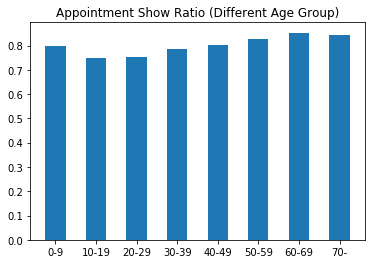

In [8]:
group_age_level = df.pivot_table('Show',  index = 'AgeLevel')
idx = np.arange(len(group_age_level.index))
plt.bar(idx,group_age_level['Show'], width = 0.5)
plt.xticks(idx,group_age_level.index)
plt.title('Appointment Show Ratio (Different Age Group)')
plt.show()

**答案 3** : 統計趨勢觀察起來，10至19及20至29這個區間，明顯較低，而60至69歲這個區間的就診出席率最高，中間區間則逐步上升，統計上可列為觀察指標之一。

**问题 4** :慢性病者(高血压、糖尿病)、酗酒或行动不便者的预约就诊率比例

In [26]:
series_handicap = []
for row in df['Handcap']:
    result = 0
    if row > 0:
        result = 1
    series_handicap.append(result)
df['IsHandicap'] = series_handicap

"""
series_no_sick = []
for idx in df.index:
    result = 0
    row = df.iloc[idx]
    if row['Hipertension'] == 1 or row['Diabetes'] == 1 or row['Alcoholism'] != 1:
        result = 1
    series_no_sick.append(result)
df['No-sick'] = series_no_sick
df.head()
"""


"\nseries_no_sick = []\nfor idx in df.index:\n    result = 0\n    row = df.iloc[idx]\n    if row['Hipertension'] == 1 or row['Diabetes'] == 1 or row['Alcoholism'] != 1:\n        result = 1\n    series_no_sick.append(result)\ndf['No-sick'] = series_no_sick\ndf.head()\n"

In [21]:
group_hyper = df.pivot_table('Show',  index = 'Hipertension')
group_diabetes = df.pivot_table('Show', index = 'Diabetes')
group_alcoholism = df.pivot_table('Show', index = 'Alcoholism')
group_handcap = df.pivot_table('Show', index = 'IsHandicap')
group_sms = df.pivot_table('Show', index = 'SMS_received')
group_no_sick = df.pivot_table('Show', index = 'No-sick')

#group_hyper, group_diabetes, group_alcoholism, group_handcap,group_sms , group_no_sick

(                  Show
 Hipertension          
 0             0.790963
 1             0.826980,               Show
 Diabetes          
 0         0.796372
 1         0.819967,                 Show
 Alcoholism          
 0           0.798054
 1           0.798512,                 Show
 IsHandicap          
 0           0.797647
 1           0.818385,                   Show
 SMS_received          
 0             0.832967
 1             0.724255,              Show
 No-sick          
 0        0.785386
 1        0.798296)

<a id='wrangling'></a>
## 数据收集和整理

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [11]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.


> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning (Replace this with more specific notes!)

In [12]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)

In [13]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Replace this header name!)

In [14]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!